This notebook demonstrates how to compute the auto power spectra and the cross power spectra for cosmic fields. Here, we use the CMB lensing signal and the CIB temperature.

In [1]:
%load_ext autoreload
%load_ext line_profiler
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import constants as scc

from quickspec import lens
from quickspec.cib import hall
from quickspec import cosmo, mps

In [3]:
plt.style.use('ggplot')

# Cosmology

We begin by defining the initial conditions and the cosmology.

In [4]:
initial_cond = mps.mps.initial_ps()

In [5]:
mycosmo = cosmo.lcdm()

In [6]:
vars(mycosmo).keys()

dict_keys(['omr', 'omb', 'omc', 'oml', 'H0', 'h', 'omm', 'zvec', 'xvec', 'zmin', 'zmax', 'xmin', 'xmax', 'spl_x_z', 'spl_z_x'])

# Matter power spectrum

In [7]:
mymps = mps.lin.mps_camb(
    cosmo=mycosmo, sips=initial_cond, nonlinear=True)

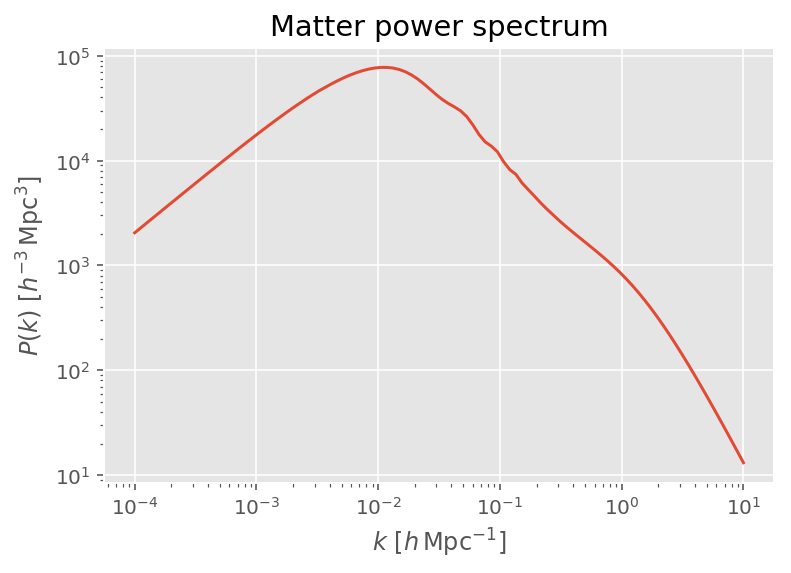

In [8]:
kk = np.logspace(-4, 1, 100)

plt.plot(kk, mymps.p_kz(kk, z=0))
plt.loglog()

# labels & legends
plt.title('Matter power spectrum')
plt.xlabel(r'$k\ [h\,\rm Mpc^{-1}]$')
plt.ylabel(r'$P(k)\ [h^{-3}\,\rm Mpc^3]$');

# Kernels

In [9]:
ls = np.arange(10, 2048., 20)

The lensing kernel used here depends only on `quickspec.cosmo`.

In [10]:
kernel_lens = lens.kern(mycosmo)

For the CIB kernel, we need the FIR frequency at which we want to evaluate the power spectrum and the parameters for the Hall+ (2010) model.

In [11]:
nu = 545.e9
zc = 2.
sigmaz = 2.
b = 0.8 / np.sqrt(2.4)

kernel_cib = hall.ssed_kern(
    nu,
    jbar_kwargs={'zc': zc, 'sigmaz': sigmaz},
    b0=b,
    b1=0.1,
    b2=0.1,
    fnl=0.001,
    mps=mymps)

We obtain the powerspectra through calls to `mps.cl_limber_z()`.

In [12]:
# CIBxCMB lensing
powspec_TP = mymps.cl_limber_z(
    kernel_cib, kernel_lens,
    ls=ls, zmin=1.e-2, zmax=20.)

In [12]:
# CIBxCIB lensing
powspec_TT = mymps.cl_limber_z(
    kernel_cib, kernel_cib,
    ls=ls, zmin=1.e-2, zmax=20.)

# CMB lensing x CMB lensing
powspec_PP = mymps.cl_limber_z(
    kernel_lens, kernel_lens,
    ls=ls, zmin=1.e-2, zmax=20.)

## Inspect power spectra

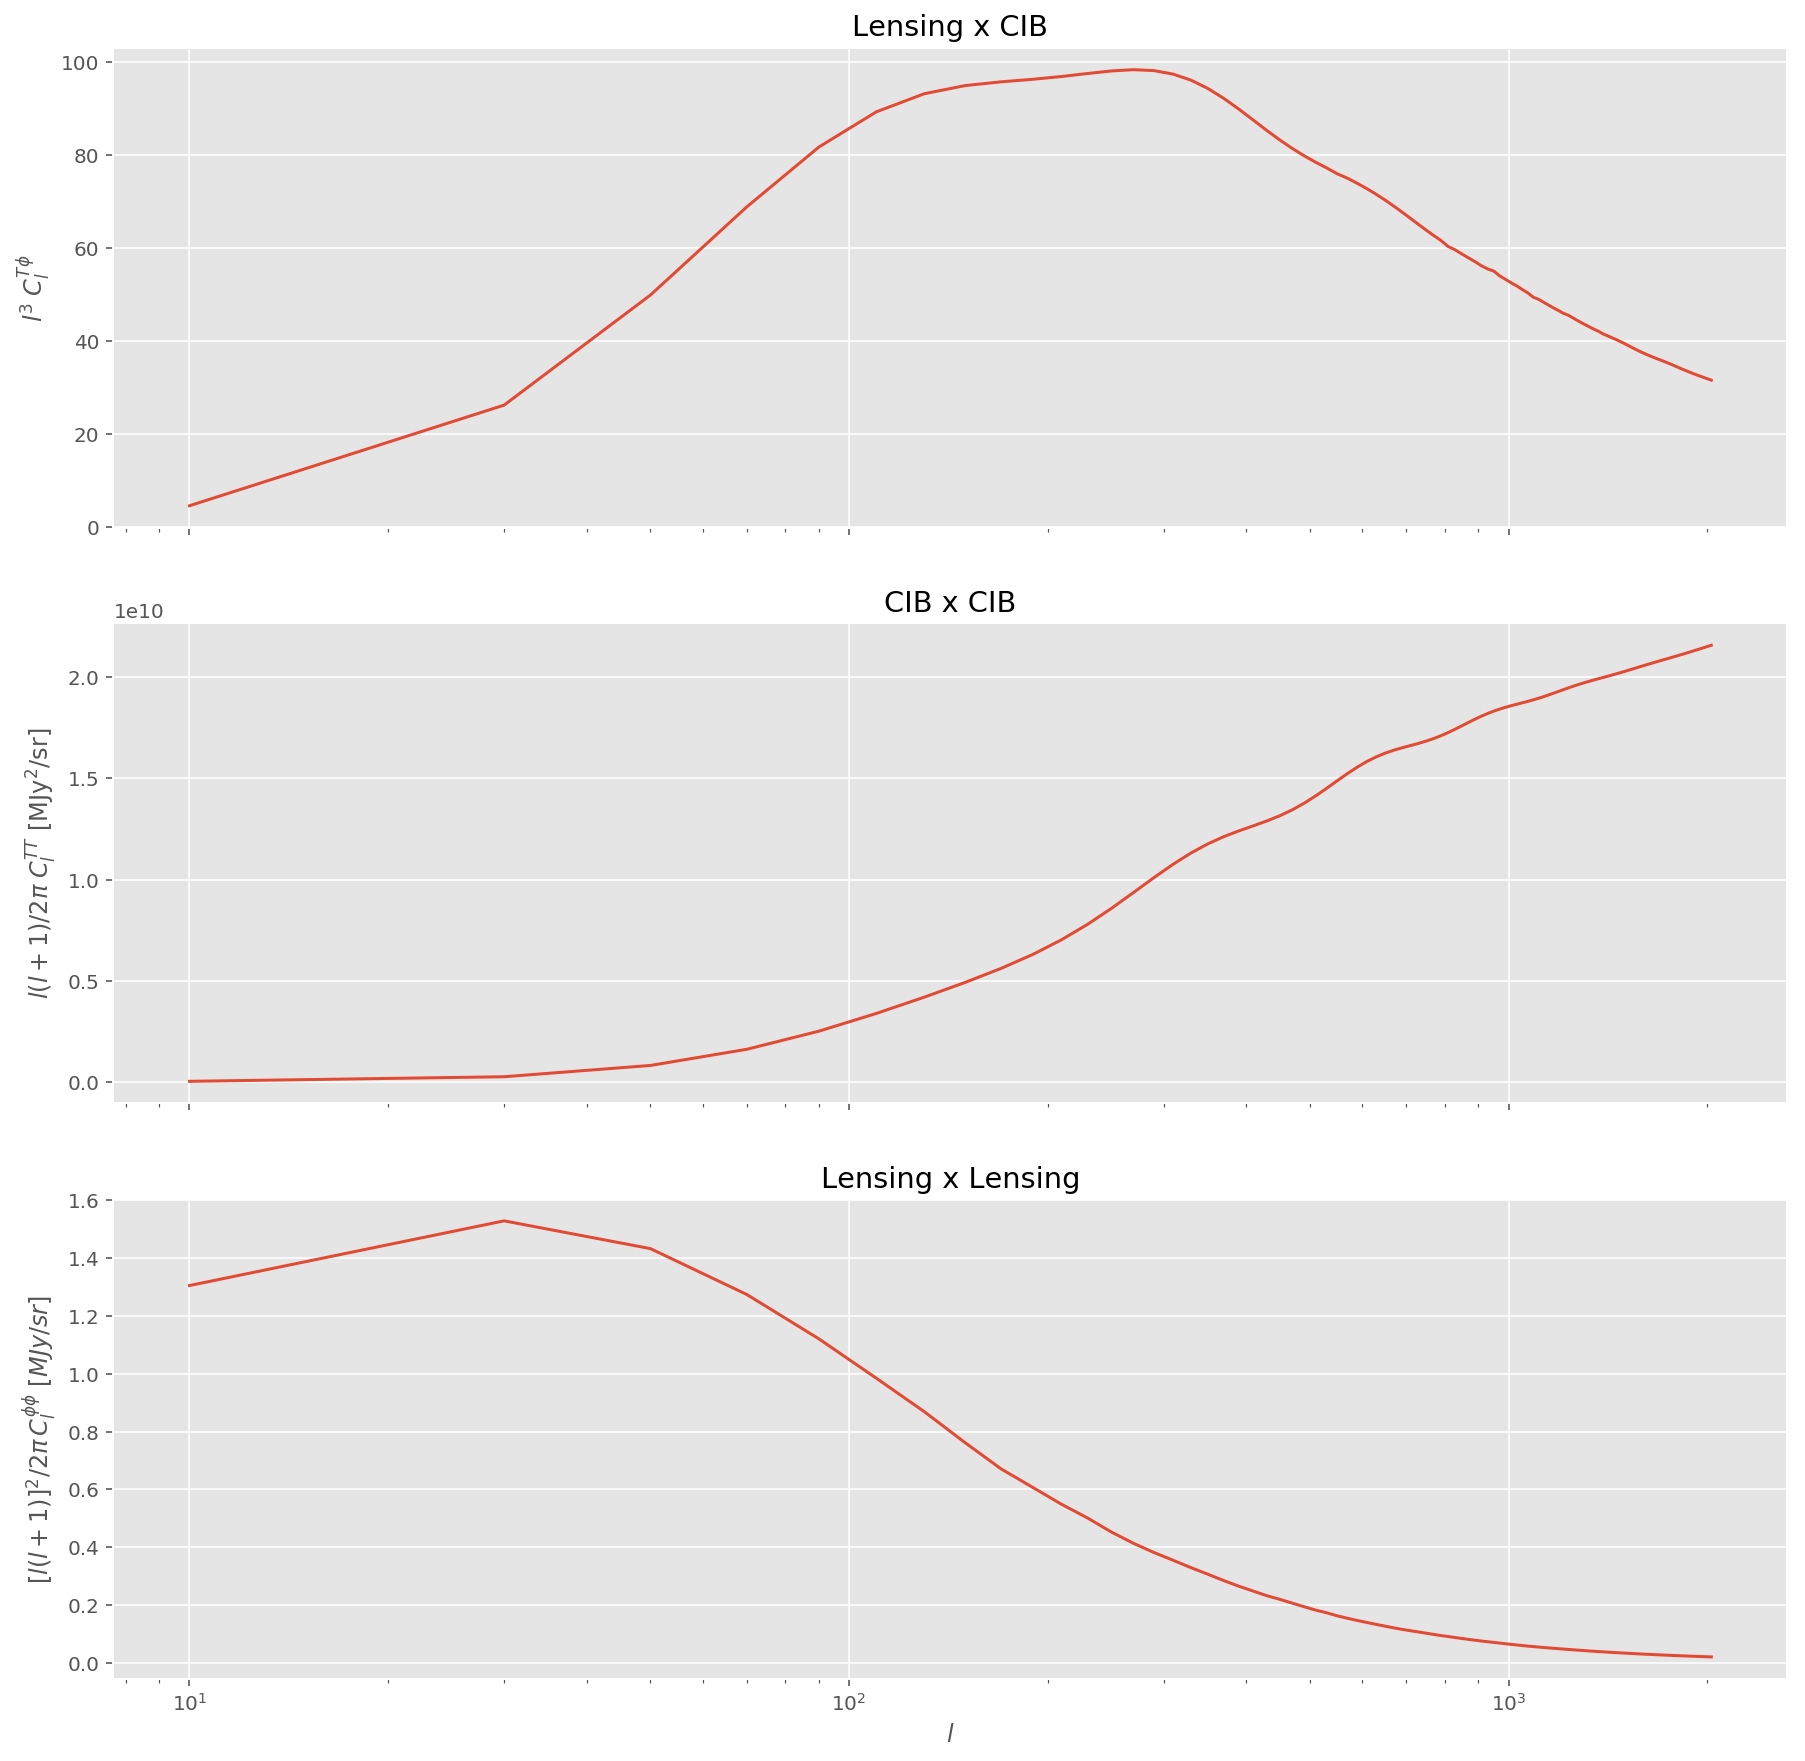

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(15, 15), nrows=3)

# TP
ax1.plot(ls, ls**3 * powspec_TP)
ax1.semilogx()
ax1.xaxis.set_ticklabels([])
ax1.set_ylabel(r'$l^3\; C_l^{T\phi}$')
ax1.set_title('Lensing x CIB')

# TT
ax2.plot(ls, ls * (ls + 1.) / 2. / np.pi * powspec_TT)
ax2.semilogx()
ax2.xaxis.set_ticklabels([])
ax2.set_ylabel(r'$l(l+1)/2\pi\; C_l^{TT}\ [\rm MJy^2/sr]$')
ax2.set_title('CIB x CIB')

# PP
ax3.plot(ls, (ls * (ls + 1.))**2. / 2. / np.pi * powspec_PP * 1.e7)
ax3.semilogx()
ax3.set_xlabel(r'$l$')
ax3.set_ylabel(r'$[l(l+1)]^2/2\pi\, C_l^{\phi\phi}\ [MJy/sr]$')
ax3.set_title('Lensing x Lensing');

# Work on scale-dependent bias

The dimensionless inital power spectrum $\Delta_{\mathcal{R}}^2(k)$ is related to the $P_{\mathcal{R}}(k)$ through:

$$\Delta_{\mathcal{R}}^2(k) = \frac{k^3}{2\pi^2} P_{\mathcal{R}}(k)$$

It is given by:
$$\Delta_{\mathcal{R}}^2(k) = A_s\; \left(\frac{k}{k_{\rm eq}}\right)^{n_s - 1}$$

In [14]:
keq = 0.05 * mycosmo.h  # convert keq = 0.05/Mpc to 0.05 h/Mpc
Deltasq_k = initial_cond.amp * (kk/keq)**(initial_cond.n_s - 1.)
pk_R = 2 * np.pi**2 / kk**3 * Deltasq_k

`Quickspec` implementation

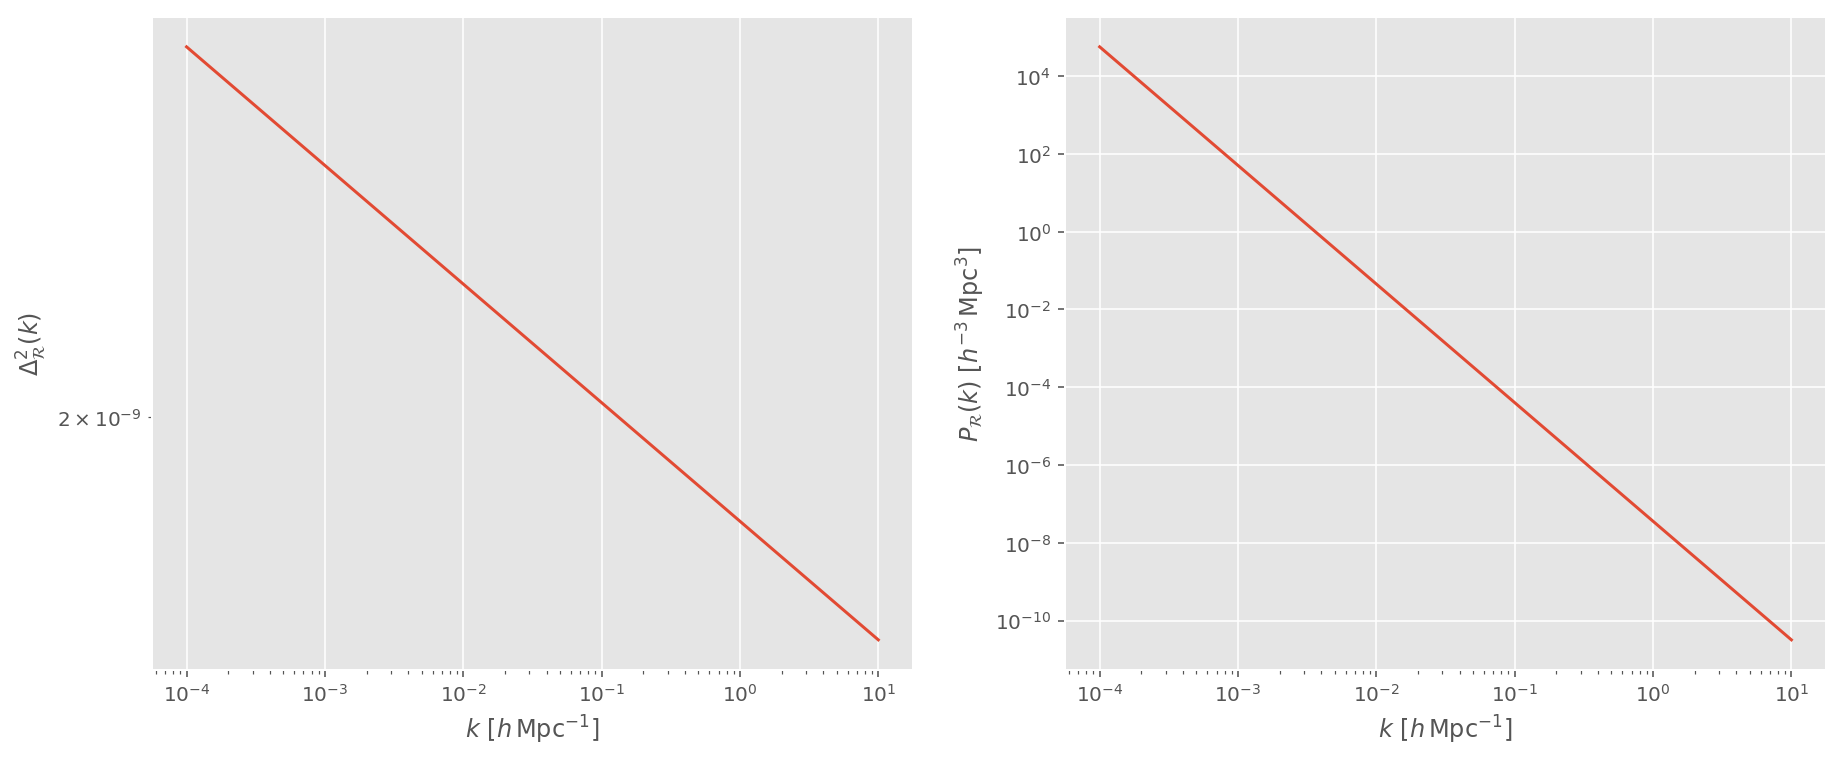

In [21]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 6))
ax1, ax2 = axes

ax1.loglog(kk, initial_cond.delta_sq(kk))
ax1.set_ylabel(r'$\Delta_{\mathcal{R}}^2(k)$')

ax2.loglog(kk, initial_cond.p_R(kk))
ax2.set_ylabel(r'$P_{\mathcal{R}}(k)\ [h^{-3}\,\rm Mpc^3]$')

for ax in axes:
    ax.set_xlabel(r'$k\ [h\,\rm Mpc^{-1}]$')

CCL implementation

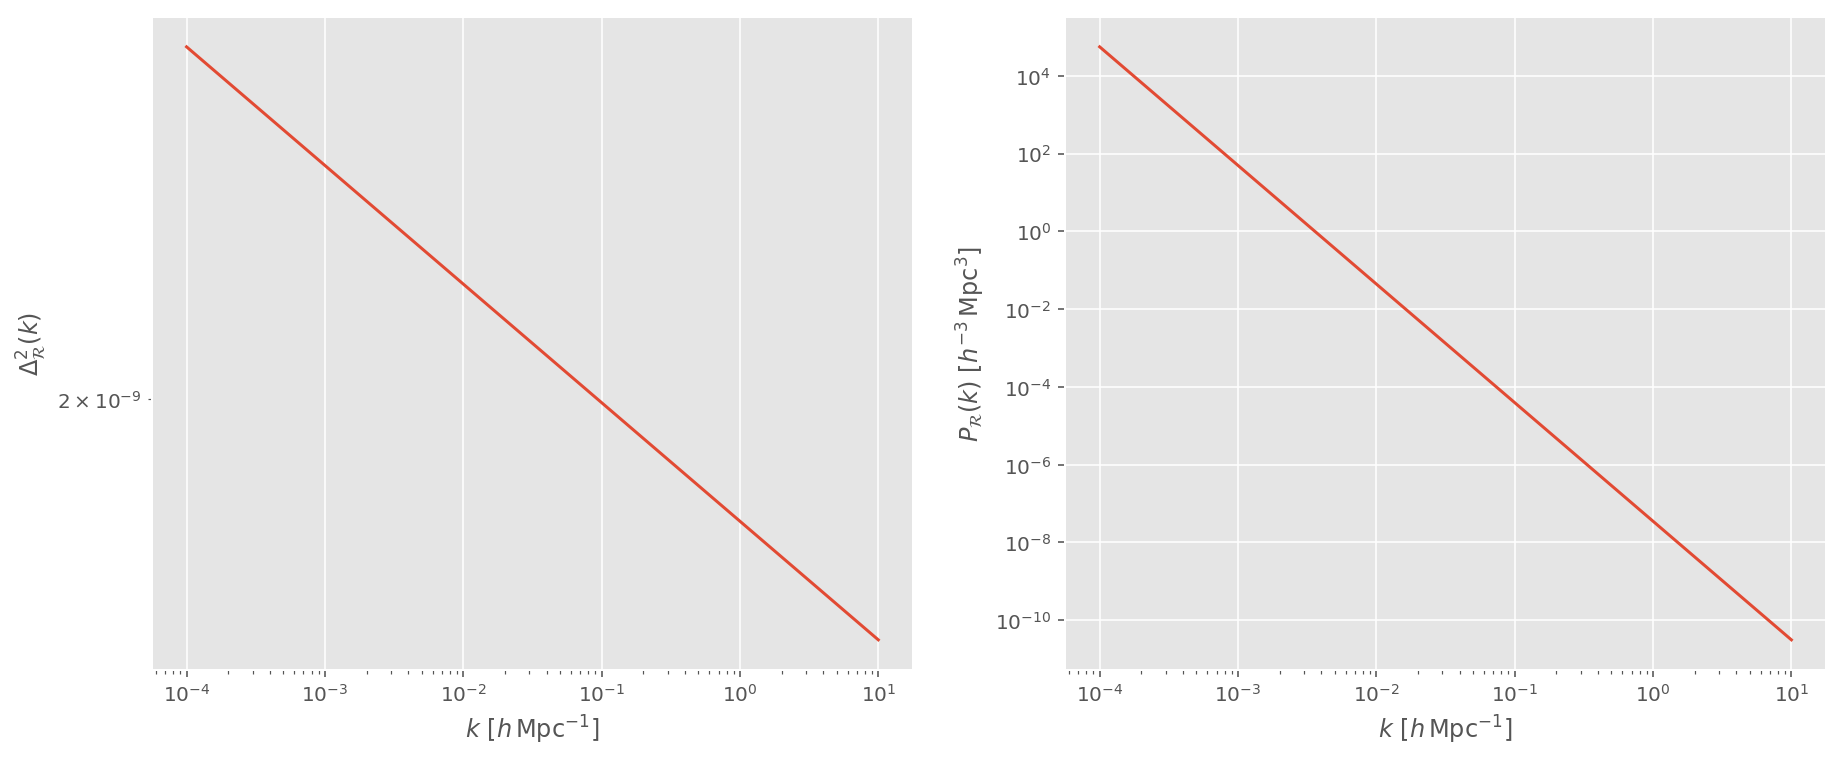

In [16]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 6))
ax1, ax2 = axes

# \Delta^2(k)
ax1.loglog(kk, Deltasq_k)
ax1.set_ylabel(r'$\Delta_{\mathcal{R}}^2(k)$');

# P_R(k)
ax2.loglog(kk, pk_R)
ax2.set_ylabel(r'$P_{\mathcal{R}}(k)\ [h^{-3}\,\rm Mpc^3]$');

for ax in axes:
    ax.set_xlabel(r'$k\ [h\,\rm Mpc^{-1}]$')

## Transfer function

The transfer function describes the growth of structures from the initial density perturbations,
$$P(k) = T^2(k)\;k^4\; P_{\mathcal{R}}(k)$$

Hence, $T(k)$ is simply defined as 
$$T(k)=k^{-2}\sqrt{\frac{P(k)}{P_{\mathcal{R}}(k)}}$$

Manual implementation

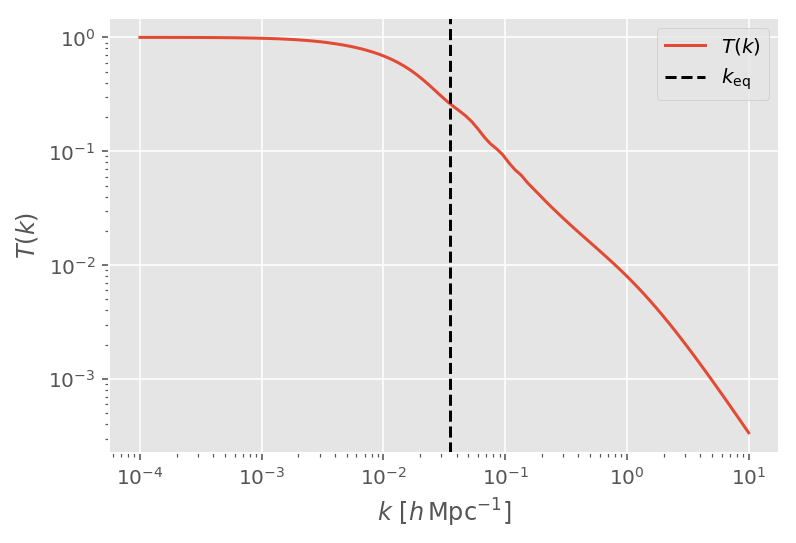

In [14]:
Tk = np.sqrt(mymps.p_kz(kk, z=0) / pk_R) / kk**2
Tk /= Tk.max()  # normalize to 1

plt.loglog(kk, Tk, label=r'$T(k)$')
plt.axvline(keq, ls='--', c='k', label=r'$k_{\rm eq}$')

# labels & legends
plt.legend()
plt.xlabel(r'$k\ [h\,\rm Mpc^{-1}]$')
plt.ylabel(r'$T(k)$');

Built-in implementation

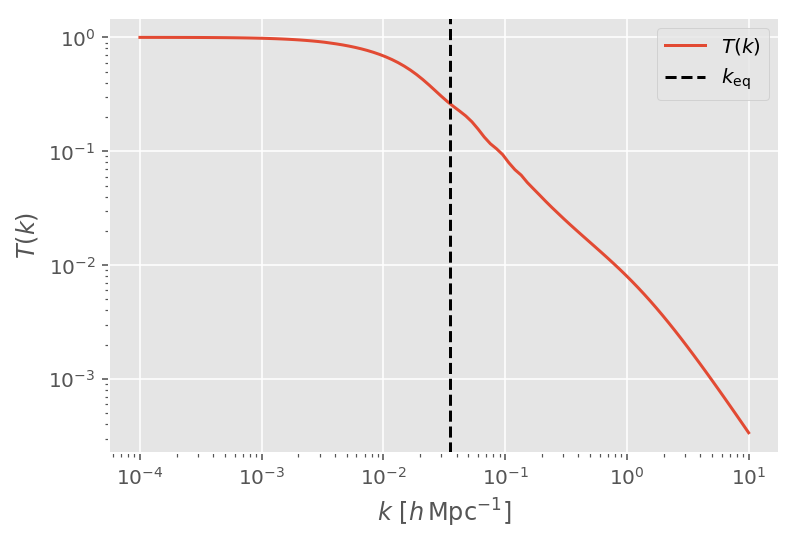

In [22]:
# Tk = np.sqrt(mymps.p_kz(kk, z=0) / pk_R) / kk**2
# Tk /= Tk.max()  # normalize to 1

plt.loglog(kk, mymps.T(kk), label=r'$T(k)$')
plt.axvline(keq, ls='--', c='k', label=r'$k_{\rm eq}$')

# labels & legends
plt.legend()
plt.xlabel(r'$k\ [h\,\rm Mpc^{-1}]$')
plt.ylabel(r'$T(k)$');

## Growth function

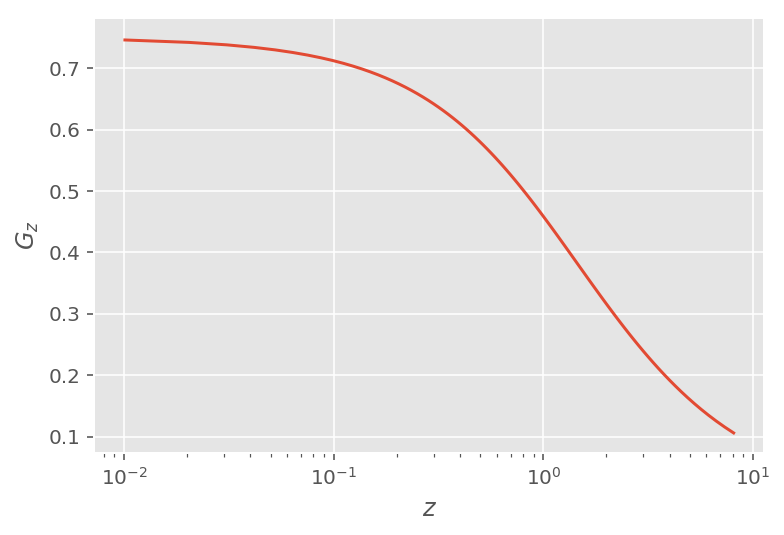

In [23]:
# scale factor and corresponding redshift vector
avec = np.arange(1., 0.1, -0.01)
zvec = (1. - avec) / avec

G_z = mycosmo.G_z(zvec)

# We re-normalize G(a) such that G(a) = a during matter domination, 
# implying G(z=0) approx 0.75
G_z /= G_z.max()
G_z *= 0.75

plt.semilogx(zvec, G_z)

plt.xlabel(r'$z$')
plt.ylabel(r'$G_z$');

## Scale-dependent bias

The following expression relates the bias to the primordial non-Gaussianity, parametrized through $f_{\rm NL}$. We note that this term $b$ is a **correction** to the bias, not the bias itself. The Eulerian, Gaussian bias $b_G$ is a parameter of this correction.

In [21]:
def b(z, b_G=1.5, fnl=1.):
    """
    Eq. (1) from de Putter+ (2014)
    """

    delta_c = 1.686  # critical overdensity
    
    bias = (
        b_G + fnl * (b_G - 1.) * delta_c * 3. * mycosmo.omm *
        (100./(scc.c/1.e3)/kk)**2 / Tk / mycosmo.G_z(z))

    return bias

## Inspect these biases for different sets of parameters

We visualize the scale-dependent correction for different redshifts and values of $f_{\rm NL}$.

In [19]:
redshifts = np.arange(4)
fnls = np.logspace(-3, 0, 5)

TypeError: 'numpy.float64' object is not callable

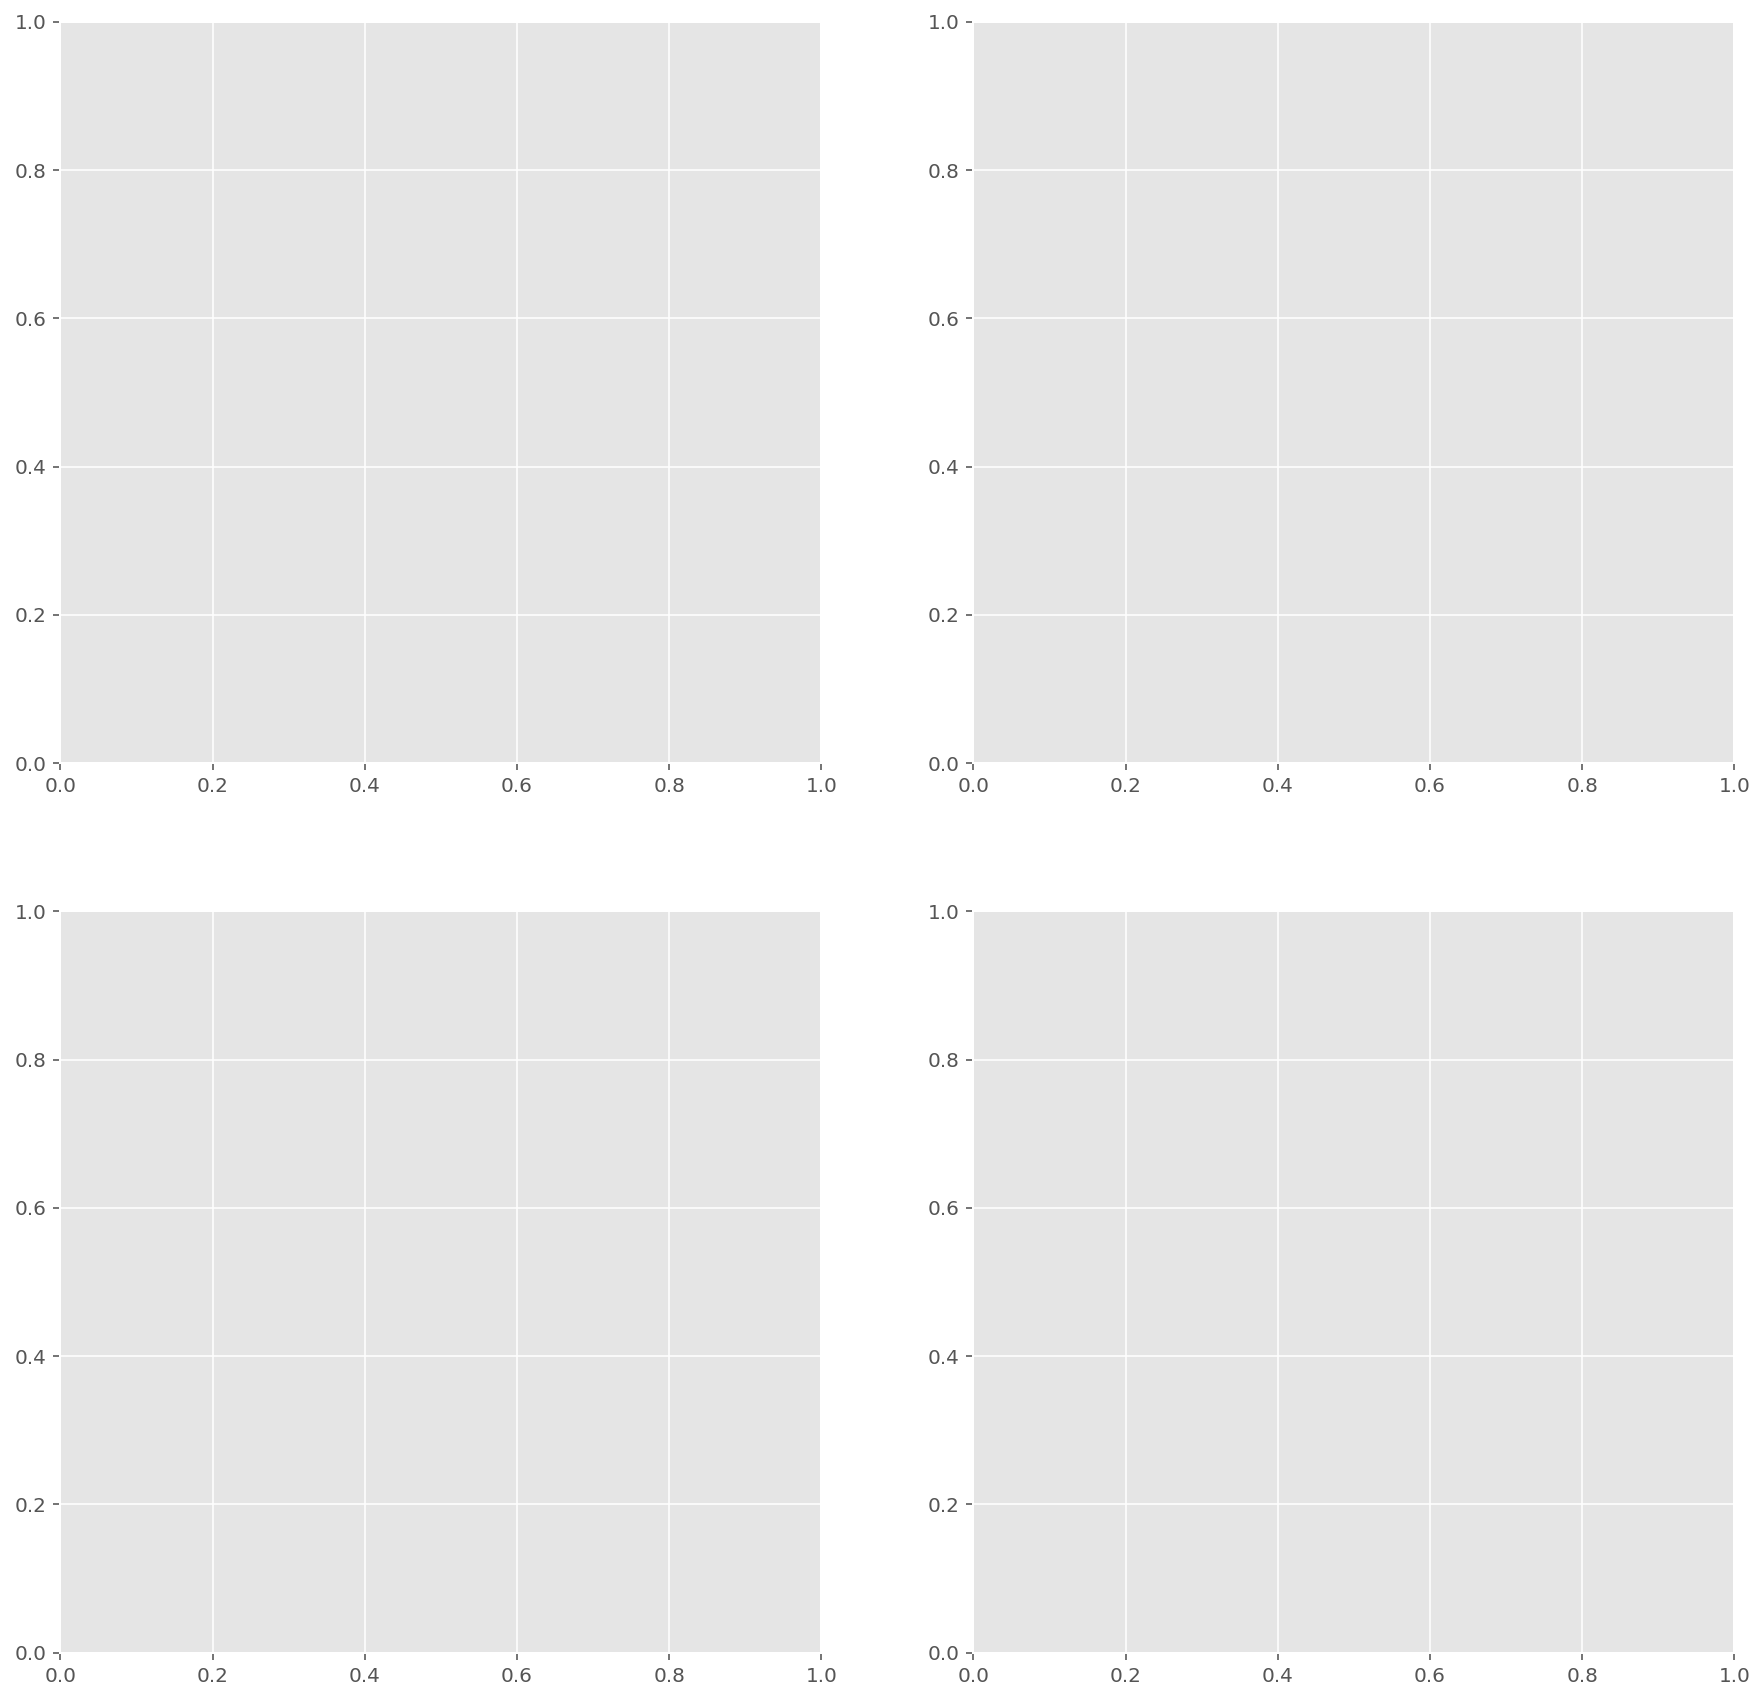

In [20]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(15, 15))
(ax1, ax2), (ax3, ax4) = axes

for ax, fnl in zip(axes.flatten(), fnls):
    [ax.plot(kk, b(z, fnl=fnl), label=f'z={z}, fnl={fnl}') for z in redshifts]
    ax.semilogx();

    ax.legend()
    ax.set_xlabel(r'$k\ [h\,\rm Mpc^{-1}]$')
    ax.set_ylabel(r'$b_k$')